# Goal: test Stim code for surface code memory experiment

In [1]:
import sys
sys.path.append('../')

import numpy as np
import sinter
import matplotlib.pyplot as plt
import copy

from stim_surface_code.patch import SurfaceCodePatch
from stim_surface_code.memory import MemoryPatch
from ray_delay.noise_model_patch import NoiseModelPatch
from ray_delay.noise_model import GoogleNoiseParamsNoRandomRays, get_T1T2_gate_err

In [2]:
GoogleNoiseParamsNoRandomRays.error_means

{'T1': 2e-05,
 'T2': 3e-05,
 'gate1_err': 7.120212737438613e-05,
 'gate2_err': 0.003979889401443166,
 'readout_err': 0.005563204917891928}

In [3]:
GoogleNoiseParamsNoRandomRays.error_stdevs

{'T1': 2e-06,
 'T2': 5e-06,
 'gate1_err': 4.450132960899133e-05,
 'gate2_err': 0.0023879336408659,
 'readout_err': 0.001390801229472982}

In [4]:
# options = {'ideal_init_and_meas': True}
options = {}

In [5]:
m = NoiseModelPatch(MemoryPatch(3,3,5))
print(m.patch.count_logical_errors(observable_basis='X', **options))
print(m.patch.count_logical_errors(observable_basis='Z', **options))

(0.0249985, 10000000)
(0.041488, 10000000)


In [6]:
noise_params = GoogleNoiseParamsNoRandomRays.improve(10)

noise_params_1 = copy.deepcopy(noise_params)
noise_params_1.error_means['T1'] *= 1
noise_params_1.error_stdevs['T1'] = 0

m = NoiseModelPatch(MemoryPatch(3,3,5), noise_params_1)
print(m.patch.error_vals['T1'][0], m.patch.total_gate1_err(0))

0.0002 8.837794085938211e-05


In [7]:
noise_params = GoogleNoiseParamsNoRandomRays.improve(10)

noise_params_1 = copy.deepcopy(noise_params)
noise_params_1.error_means['T1'] *= 0.1
noise_params_1.error_stdevs['T1'] = 0

m = NoiseModelPatch(MemoryPatch(3,3,5), noise_params_1)
print(m.patch.error_vals['T1'][0], m.patch.total_gate1_err(0))

2e-05 0.0006341277921474655


In [8]:
noise_params = GoogleNoiseParamsNoRandomRays.improve(10)

noise_params_1 = copy.deepcopy(noise_params)
noise_params_1.error_means['T1'] *= 0.01
noise_params_1.error_stdevs['T1'] = 0

m = NoiseModelPatch(MemoryPatch(3,3,5), noise_params_1)
print(m.patch.error_vals['T1'][0], m.patch.total_gate1_err(0))

2.0000000000000003e-06 0.006217951066656177


In [9]:
noise_params = GoogleNoiseParamsNoRandomRays.improve(10)

noise_params_1 = copy.deepcopy(noise_params)
noise_params_1.error_means['T1'] *= 0.001
noise_params_1.error_stdevs['T1'] = 0

m = NoiseModelPatch(MemoryPatch(3,3,5), noise_params_1)
print(m.patch.error_vals['T1'][0], m.patch.total_gate1_err(0))

2.0000000000000002e-07 0.058761387921183586


In [10]:
m = NoiseModelPatch(MemoryPatch(3,5,5))
print(m.patch.count_logical_errors(observable_basis='X', **options))
print(m.patch.count_logical_errors(observable_basis='Z', **options))

(0.0003005, 10000000)
(0.0818787, 10000000)


In [11]:
m = NoiseModelPatch(MemoryPatch(5,3,5))
print(m.patch.count_logical_errors(observable_basis='X', **options))
print(m.patch.count_logical_errors(observable_basis='Z', **options))

(0.0519767, 10000000)
(0.0004463, 10000000)


In [12]:
m = NoiseModelPatch(MemoryPatch(5,5,5))
print(m.patch.count_logical_errors(observable_basis='X', **options))
print(m.patch.count_logical_errors(observable_basis='Z', **options))

(0.0006799, 10000000)
(0.001127, 10000000)


In [13]:
m = NoiseModelPatch(MemoryPatch(3,5,5))
m.patch

--------------------------------------------------------
|    |    |X 15|    |    |    |X 16|    |    |    |    |
----------+----+--------------+----+--------------------
|    |   0|    |   1|    |   2|    |   3|    |   4|    |
----------+----+----+----+----+----+----+----+----+-----
|    |    |Z 17|    |X 18|    |Z 19|    |X 20|    |Z 21|
----------+----+----+----+----+----+----+----+----+-----
|    |L  5|    |L  6|    |L  7|    |L  8|    |L  9|    |
-----+----+----+----+----+----+----+----+----+----------
|Z 22|    |X 23|    |Z 24|    |X 25|    |Z 26|    |    |
-----+----+----+----+----+----+----+----+----+----------
|    |  10|    |  11|    |  12|    |  13|    |  14|    |
--------------------+----+--------------+----+----------
|    |    |    |    |X 27|    |    |    |X 28|    |    |
--------------------------------------------------------

In [14]:
import numpy as np

In [15]:
tasks = []
for improvement_factor in np.geomspace(100, 1, 7):
    for d in [3,5,7,9]:
        m = NoiseModelPatch(MemoryPatch(d, d, d), GoogleNoiseParamsNoRandomRays.improve(improvement_factor))
        circ = m.patch.get_stim()
        tasks.append(sinter.Task(circuit=circ, json_metadata={'f': improvement_factor, 'd': d}))

In [16]:
samples = sinter.collect(
    num_workers=6,
    max_shots=1_000_000,
    max_errors=500,
    tasks=tasks,
    decoders=['pymatching']
)

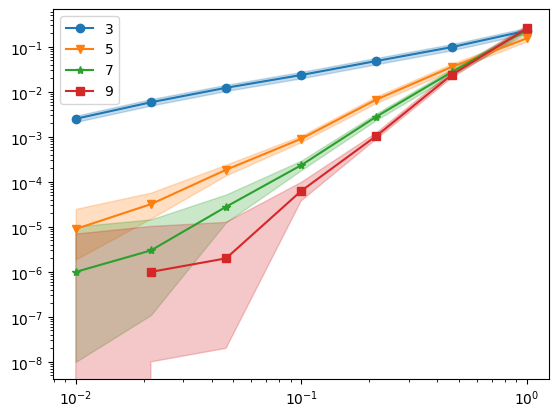

In [17]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=samples,
    x_func=lambda stats: 1/stats.json_metadata['f'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.legend()